In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("C:\\Users\\AK\\Downloads\\nn_train.csv")
X = data.iloc[:, 1:1025].values.astype(np.float32)
y = data.iloc[:, 1026].values.astype(int) - 1

In [4]:
num_classes = 10
y_one_hot = np.eye(num_classes)[y]

In [5]:
split_length = int(0.8 * len(y))
X_train, X_dev = X[:split_length], X[split_length:]
y_train, y_dev = y_one_hot[:split_length], y_one_hot[split_length:]

In [6]:
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train = (X_train - X_train_mean) / (X_train_std + 1e-8)
X_dev = (X_dev - X_train_mean) / (X_train_std + 1e-8)

In [7]:
layer_sizes = [X.shape[1], 128, 64, num_classes]
learning_rate = 0.0001
epochs = 50
batch_size = 64
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
lambda_reg = 1

In [8]:
parameters = {}
adam_m = {}
adam_v = {}
t = 0

In [9]:
np.random.seed(42)
for i in range(1, len(layer_sizes)):
    parameters[f"W{i}"] = np.random.randn(layer_sizes[i - 1], layer_sizes[i]).astype(np.float32) * np.sqrt(2 / layer_sizes[i - 1])
    parameters[f"b{i}"] = np.zeros((1, layer_sizes[i]), dtype=np.float32)
    adam_m[f"dW{i}"] = np.zeros_like(parameters[f"W{i}"])
    adam_v[f"dW{i}"] = np.zeros_like(parameters[f"W{i}"])
    adam_m[f"db{i}"] = np.zeros_like(parameters[f"b{i}"])
    adam_v[f"db{i}"] = np.zeros_like(parameters[f"b{i}"])

In [10]:
def relu(Z):
    return np.maximum(0, Z)

In [11]:
def relu_derivative(Z):
    return (Z > 0).astype(np.float32)

In [12]:
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

In [13]:
def forward_propagation(X, parameters):
    cache = {"A0": X}
    L = len(parameters) // 2
    for l in range(1, L + 1):
        Z = np.dot(cache[f"A{l-1}"], parameters[f"W{l}"]) + parameters[f"b{l}"]
        A = softmax(Z) if l == L else relu(Z)
        cache[f"Z{l}"] = Z
        cache[f"A{l}"] = A
    return cache[f"A{L}"], cache

In [14]:
def backward_propagation(X, y, parameters, cache, lambda_reg):
    gradients = {}
    L = len(parameters) // 2
    m = X.shape[0]
    dZ = cache[f"A{L}"] - y
    for l in range(L, 0, -1):
        dW = np.dot(cache[f"A{l-1}"].T, dZ) / m + (lambda_reg / m) * parameters[f"W{l}"]
        db = np.sum(dZ, axis=0, keepdims=True) / m
        gradients[f"dW{l}"] = dW
        gradients[f"db{l}"] = db
        if l > 1:
            dA_prev = np.dot(dZ, parameters[f"W{l}"].T)
            dZ = dA_prev * relu_derivative(cache[f"Z{l-1}"])
    return gradients

In [15]:
def update_parameters_with_adam(parameters, gradients, adam_m, adam_v, t, beta1, beta2, learning_rate, epsilon):
    L = len(parameters) // 2
    t += 1
    for l in range(1, L + 1):
        adam_m[f"dW{l}"] = beta1 * adam_m[f"dW{l}"] + (1 - beta1) * gradients[f"dW{l}"]
        adam_m[f"db{l}"] = beta1 * adam_m[f"db{l}"] + (1 - beta1) * gradients[f"db{l}"]
        adam_v[f"dW{l}"] = beta2 * adam_v[f"dW{l}"] + (1 - beta2) * np.square(gradients[f"dW{l}"])
        adam_v[f"db{l}"] = beta2 * adam_v[f"db{l}"] + (1 - beta2) * np.square(gradients[f"db{l}"])
        m_dW_corrected = adam_m[f"dW{l}"] / (1 - beta1 ** t)
        m_db_corrected = adam_m[f"db{l}"] / (1 - beta1 ** t)
        v_dW_corrected = adam_v[f"dW{l}"] / (1 - beta2 ** t)
        v_db_corrected = adam_v[f"db{l}"] / (1 - beta2 ** t)
        parameters[f"W{l}"] -= learning_rate * m_dW_corrected / (np.sqrt(v_dW_corrected) + epsilon)
        parameters[f"b{l}"] -= learning_rate * m_db_corrected / (np.sqrt(v_db_corrected) + epsilon)
    return t

In [16]:
def compute_loss(A, y, parameters, lambda_reg):
    m = y.shape[0]
    cross_entropy_loss = -np.sum(y * np.log(A + 1e-8)) / m
    L2_loss = (lambda_reg / (2 * m)) * sum(np.sum(np.square(parameters[f"W{l}"])) for l in range(1, len(parameters) // 2 + 1))
    return cross_entropy_loss + L2_loss

In [17]:
def compute_accuracy(X, y, parameters):
    A, _ = forward_propagation(X, parameters)
    predictions = np.argmax(A, axis=1)
    true_labels = np.argmax(y, axis=1)
    return np.mean(predictions == true_labels)

In [18]:
def create_mini_batches(X, y, batch_size):
    m = X.shape[0]
    permutation = np.random.permutation(m)
    X_shuffled = X[permutation]
    y_shuffled = y[permutation]
    mini_batches = []
    for i in range(0, m, batch_size):
        X_batch = X_shuffled[i:i + batch_size]
        y_batch = y_shuffled[i:i + batch_size]
        mini_batches.append((X_batch, y_batch))
    return mini_batches

In [19]:
train_accuracies = []
dev_accuracies = []
losses = []

In [20]:
for epoch in range(epochs):
    mini_batches = create_mini_batches(X_train, y_train, batch_size)
    for X_batch, y_batch in mini_batches:
        A, cache = forward_propagation(X_batch, parameters)
        loss = compute_loss(A, y_batch, parameters, lambda_reg)
        gradients = backward_propagation(X_batch, y_batch, parameters, cache, lambda_reg)
        t = update_parameters_with_adam(parameters, gradients, adam_m, adam_v, t, beta1, beta2, learning_rate, epsilon)
    train_acc = compute_accuracy(X_train, y_train, parameters)
    dev_acc = compute_accuracy(X_dev, y_dev, parameters)
    train_accuracies.append(train_acc)
    dev_accuracies.append(dev_acc)
    losses.append(loss)
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss:.4f} - Train Accuracy: {train_acc:.4f} - Dev Accuracy: {dev_acc:.4f}")

Epoch 1/50 - Loss: 3.9972 - Train Accuracy: 0.3934 - Dev Accuracy: 0.3777
Epoch 2/50 - Loss: 3.4727 - Train Accuracy: 0.4373 - Dev Accuracy: 0.4179
Epoch 3/50 - Loss: 2.8240 - Train Accuracy: 0.4633 - Dev Accuracy: 0.4404
Epoch 4/50 - Loss: 2.4896 - Train Accuracy: 0.4787 - Dev Accuracy: 0.4539
Epoch 5/50 - Loss: 2.4200 - Train Accuracy: 0.4891 - Dev Accuracy: 0.4689
Epoch 6/50 - Loss: 2.2133 - Train Accuracy: 0.4993 - Dev Accuracy: 0.4756
Epoch 7/50 - Loss: 1.9532 - Train Accuracy: 0.5095 - Dev Accuracy: 0.4876
Epoch 8/50 - Loss: 1.7979 - Train Accuracy: 0.5155 - Dev Accuracy: 0.4926
Epoch 9/50 - Loss: 1.8708 - Train Accuracy: 0.5204 - Dev Accuracy: 0.4943
Epoch 10/50 - Loss: 1.8180 - Train Accuracy: 0.5252 - Dev Accuracy: 0.4985
Epoch 11/50 - Loss: 1.6638 - Train Accuracy: 0.5291 - Dev Accuracy: 0.5048
Epoch 12/50 - Loss: 1.6553 - Train Accuracy: 0.5326 - Dev Accuracy: 0.5084
Epoch 13/50 - Loss: 1.6296 - Train Accuracy: 0.5372 - Dev Accuracy: 0.5102
Epoch 14/50 - Loss: 1.5826 - Train

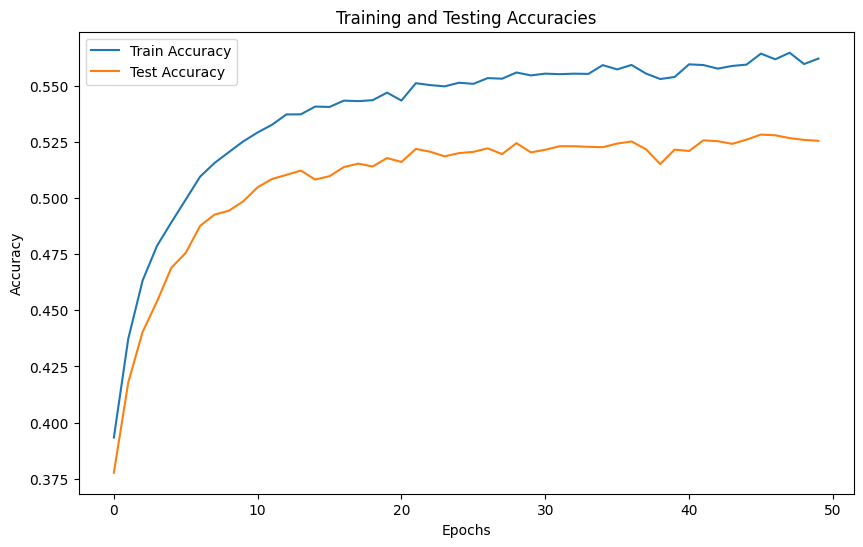

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(dev_accuracies, label='Test Accuracy')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

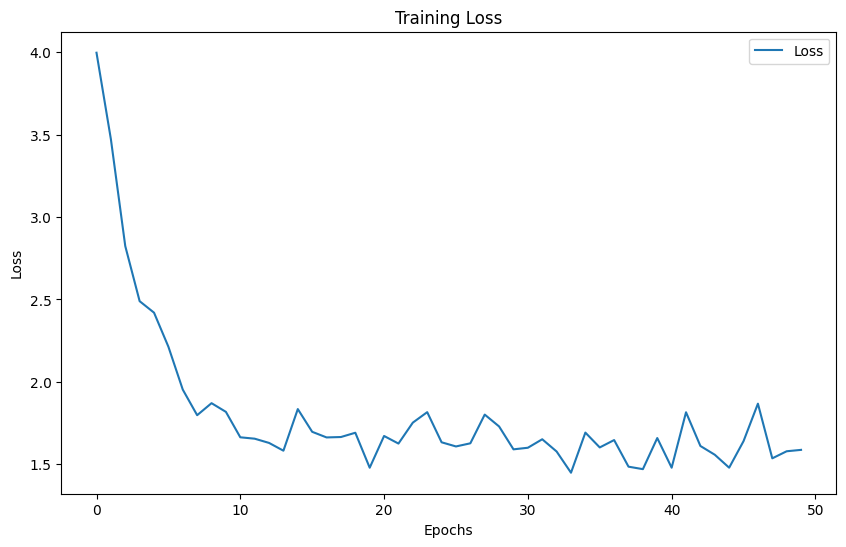

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
A, _ = forward_propagation(X_dev, parameters)
y_true_dev = np.argmax(y_dev, axis=1)
y_pred_dev = np.argmax(A, axis=1) 

In [24]:
A1, _ = forward_propagation(X_train, parameters)
y_true_train = np.argmax(y_train, axis=1)
y_pred_train = np.argmax(A1, axis=1) 

In [25]:
def calculate_precision(y_true, y_pred):
    classes = np.unique(y_true)
    precisions = []
    for cls in classes:
        tp = np.sum((y_true==cls) & (y_pred==cls))
        fp = np.sum((y_true != cls) & (y_pred==cls))
        precision = (tp / (tp + fp)) if (tp + fp) != 0 else 0
        precisions.append(precision)
    return np.mean(precisions)

In [26]:
train_precision = calculate_precision(y_true_train, y_pred_train)
dev_precision = calculate_precision(y_true_dev, y_pred_dev)

In [27]:
print(f"The Training Precision is {train_precision}")
print(f"The Development Precision is {dev_precision}")

The Training Precision is 0.5635812505222473
The Development Precision is 0.5277707857477811


In [28]:
def calculate_recall(y_true, y_pred):
    classes = np.unique(y_true)
    recalls = []
    for cls in classes:
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))
        recall = (tp / (tp + fn)) if (tp + fn) != 0 else 0
        recalls.append(recall)
    return np.mean(recalls)

In [29]:
train_recall = calculate_recall(y_true_train, y_pred_train)
dev_recall = calculate_recall(y_true_dev, y_pred_dev)

In [30]:
print(f"The Training Recall is {train_recall}")
print(f"The Development Recall is {dev_recall}")

The Training Recall is 0.5619269057344967
The Development Recall is 0.5259076489393166


In [31]:
def f1_score(precision, recall):
    return (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

In [32]:
train_f1_score = f1_score(train_precision, train_recall)
dev_f1_score = f1_score(dev_precision, dev_recall)
print(f"The Training F1 SCORE IS {train_f1_score}")
print(f"The  F1 SCORE IS {train_f1_score}")

The Training F1 SCORE IS 0.5627528622968111
The  F1 SCORE IS 0.5627528622968111
